In [6]:
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def plot_output_vs_input10(
    DATA_PATH,
    MODEL_PATH,
    SCALER_X_PATH,
    SCALER_Y_PATH,
    HIDDEN_DIMS,
    ACTIVATION,
    ROW_INDEX
):
    """
    For a given test CSV, a trained PyTorch model and its scalers,
    sweep Input 10 in [0,3000] and plot the model output vs Input 10.
    If ROW_INDEX == -2, repeat for every row in the CSV.
    """
    # --- 1) Load data and scalers ---
    df = pd.read_csv(DATA_PATH)
    with open(SCALER_X_PATH, 'rb') as f:
        scaler_X = pickle.load(f)
    with open(SCALER_Y_PATH, 'rb') as f:
        scaler_y = pickle.load(f)

    # --- 2) One‐hot categories for Inputs 1–8 ---
    categories_map = {
        'Input 1': [1, 2],
        'Input 2': [1, 2, 3, 4, 5],
        'Input 3': [1, 2, 3, 4, 5],
        'Input 4': list(range(1, 18)),
        'Input 5': list(range(1, 6)),
        'Input 6': [1, 2, 3],
        'Input 7': [1, 2, 3, 4],
        'Input 8': list(range(1, 11)),
    }

    # --- 3) Model‐builder utility ---
    def build_model(input_dim, hidden_dims, activation):
        act_name = activation.strip()
        layers = []
        in_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            if act_name.lower() not in ('linear', 'none'):
                layers.append(getattr(nn, act_name)())
            in_dim = h
        layers.append(nn.Linear(in_dim, 1))
        return nn.Sequential(*layers)

    # --- 4) Instantiate & load the model ---
    cat_dim = sum(len(v) for v in categories_map.values())
    num_dim = scaler_X.scale_.shape[0]
    input_dim = cat_dim + num_dim

    model = build_model(input_dim, HIDDEN_DIMS, ACTIVATION)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()

    # --- 5) Feature‐vector constructor given x10 and fixed_inputs ---
    def make_feature_vector(x10, fixed_inputs):
        # compute Input 12
        x11 = fixed_inputs['Input 11']
        x12 = 42.0 * x10 / x11

        # one‐hot Inputs 1–8
        cat_parts = []
        for i in range(1, 9):
            name = f'Input {i}'
            onehot = [1.0 if fixed_inputs[name] == c else 0.0 for c in categories_map[name]]
            cat_parts.extend(onehot)
        cat_arr = np.array(cat_parts, dtype=np.float32).reshape(1, -1)

        # numeric Inputs 9–18 (with x10 and computed x12)
        num_vals = []
        for i in range(9, 19):
            name = f'Input {i}'
            if i == 10:
                num_vals.append(x10)
            elif i == 12:
                num_vals.append(x12)
            else:
                num_vals.append(fixed_inputs[name])
        num_arr = np.array(num_vals, dtype=np.float32).reshape(1, -1)

        # normalize
        num_scaled = ((num_arr - scaler_X.mean_) / scaler_X.scale_).astype(np.float32)

        # concatenate
        return np.hstack([cat_arr, num_scaled]).astype(np.float32)

    # --- 6) Decide which rows to process ---
    if ROW_INDEX == -2:
        indices = range(len(df))
    else:
        if ROW_INDEX < 0 or ROW_INDEX >= len(df):
            raise IndexError(f"ROW_INDEX {ROW_INDEX} out of range (0–{len(df)-1})")
        indices = [ROW_INDEX]

    # --- 7) For each selected row, sweep and plot ---
    for idx in indices:
        row = df.iloc[idx]
        # extract fixed inputs (all except 10 & 12)
        fixed_inputs = {
            f'Input {i}': row[f'Input {i}']
            for i in range(1, 19)
            if i not in (10, 12)
        }
        actual_x10 = row['Input 10']
        actual_y  = row['Output 1']

        # sweep
        x10_vals = np.linspace(0.0, 3000.0, 2000)
        y_preds  = []
        with torch.no_grad():
            for x10 in x10_vals:
                X_feat    = make_feature_vector(x10, fixed_inputs)
                pred_norm = model(torch.from_numpy(X_feat)).cpu().numpy().ravel()[0]
                pred_orig = scaler_y.inverse_transform([[pred_norm]])[0, 0]
                y_preds.append(pred_orig)

        # plot
        plt.figure()
        plt.plot(x10_vals, y_preds, '-o', markersize=3, label='Model curve')
        plt.scatter(
            actual_x10, actual_y,
            color='red', marker='X', s=100,
            label=f'Actual (x10={actual_x10:.2f})'
        )
        plt.xlabel('Input 10')
        plt.ylabel('Neural Net Output')
        plt.title(f'Row {idx}: Output vs. Input 10\n(Input12 = 42×10/Input11)')
        plt.legend()
        plt.tight_layout()
        plt.show()


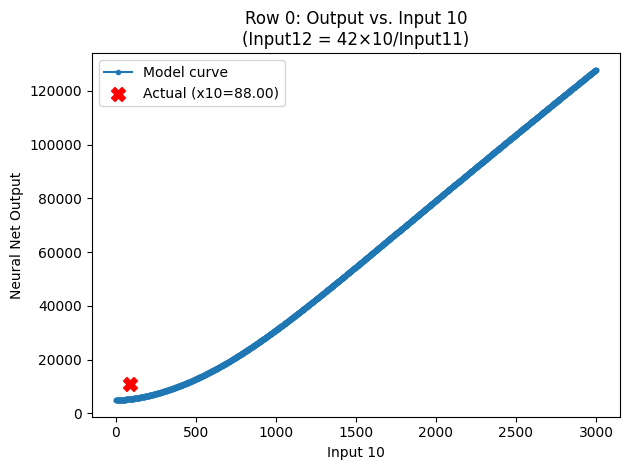

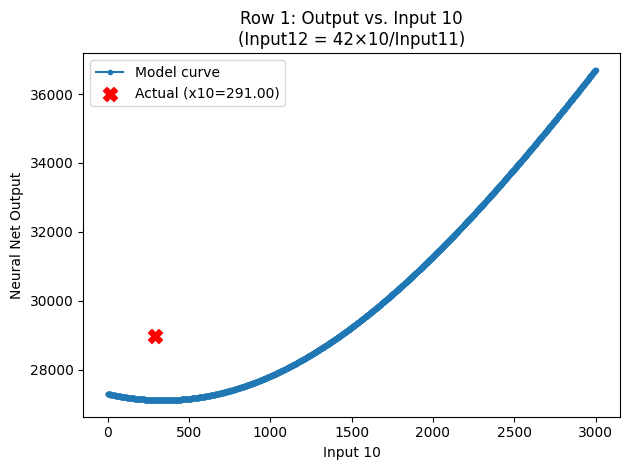

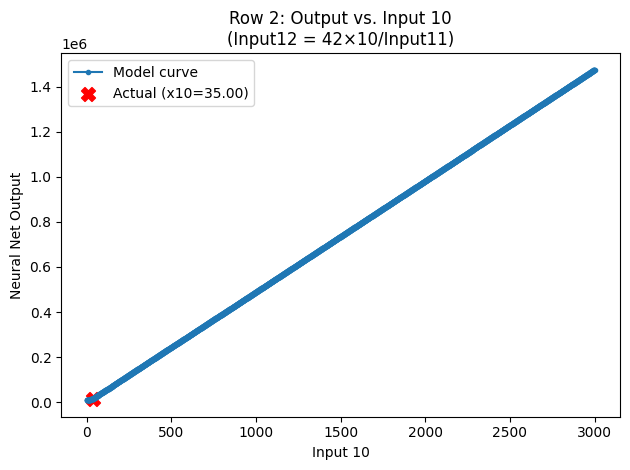

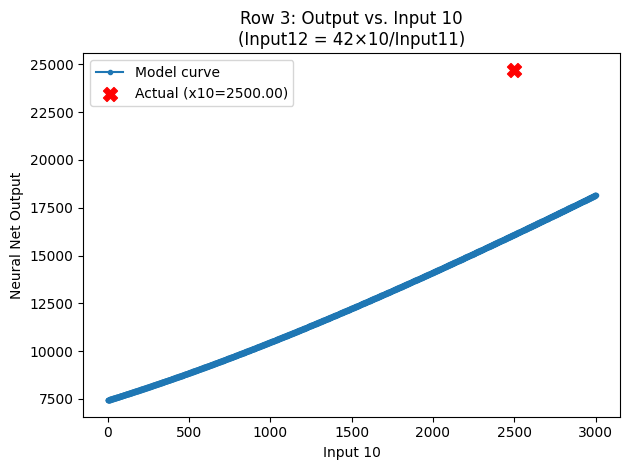

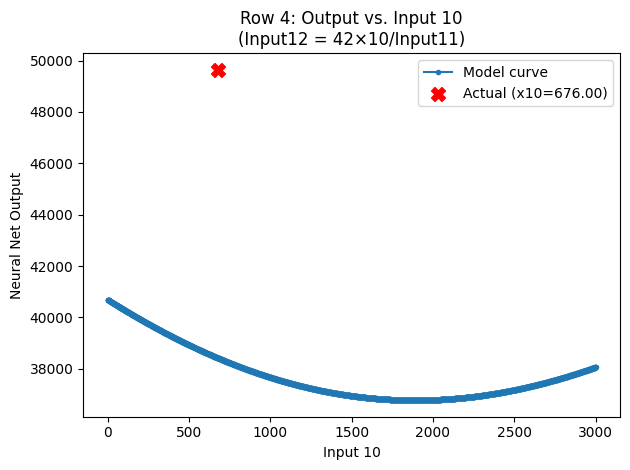

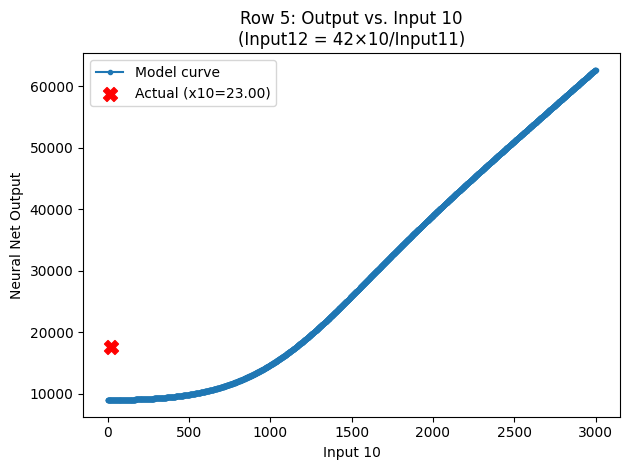

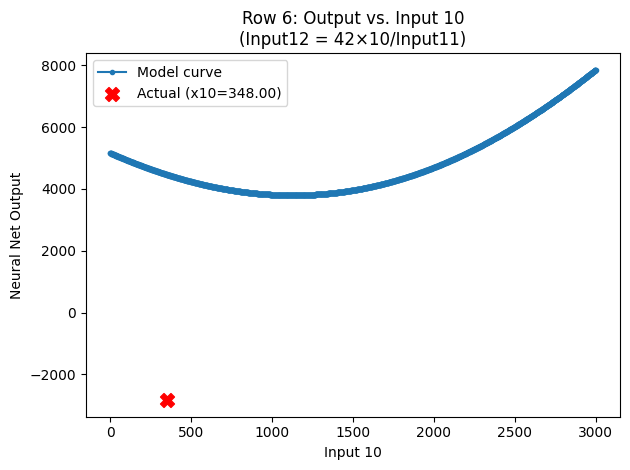

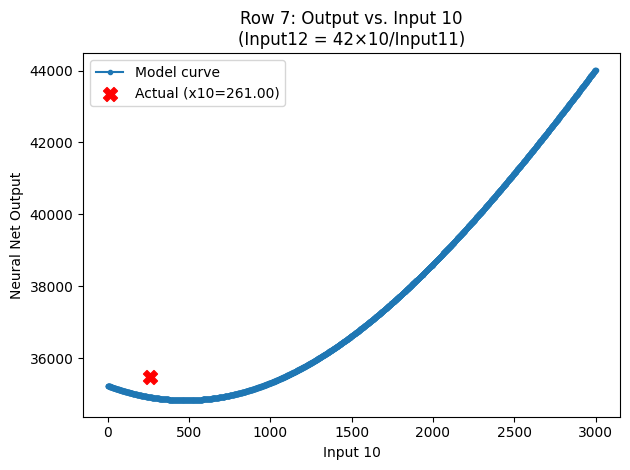

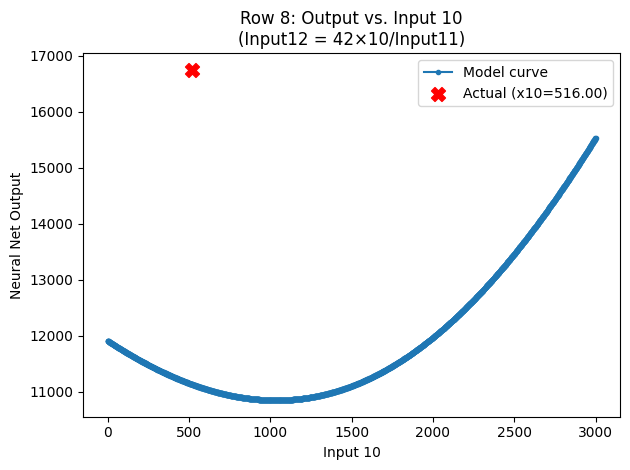

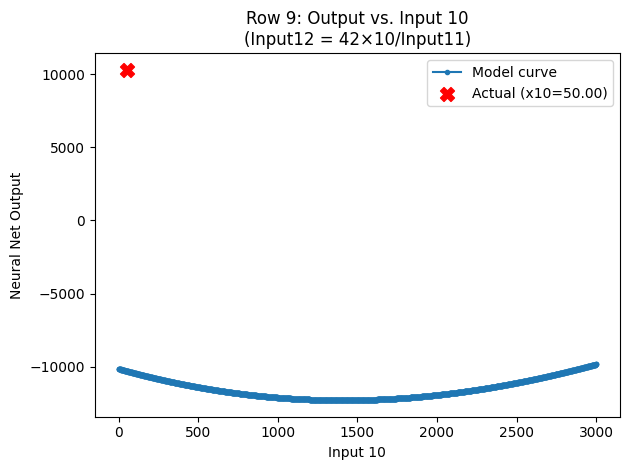

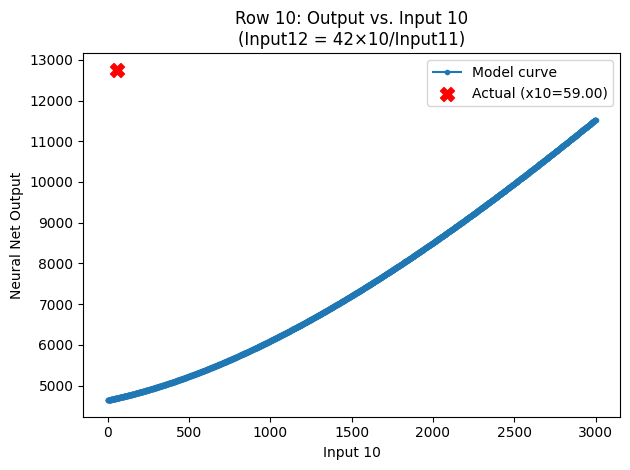

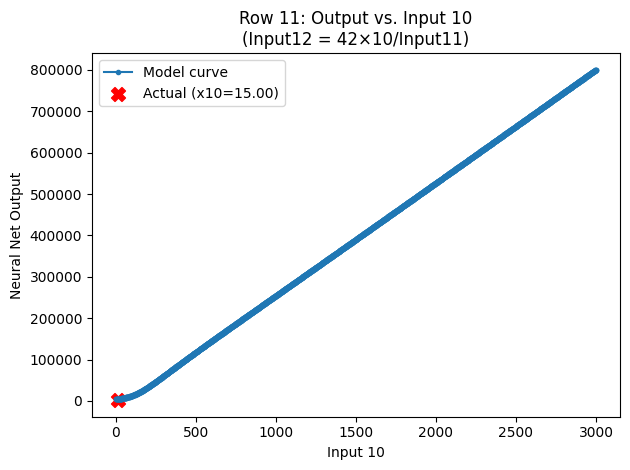

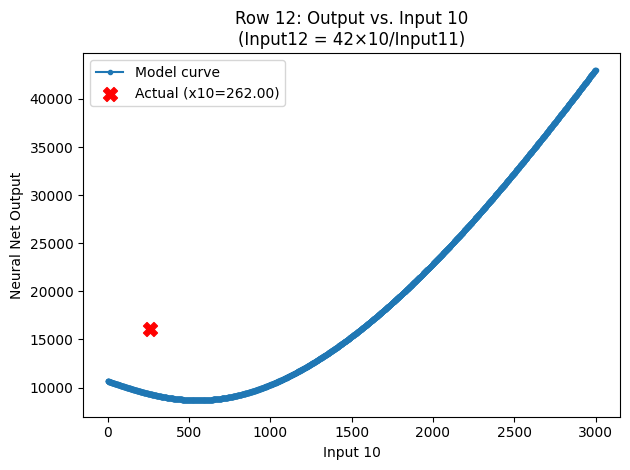

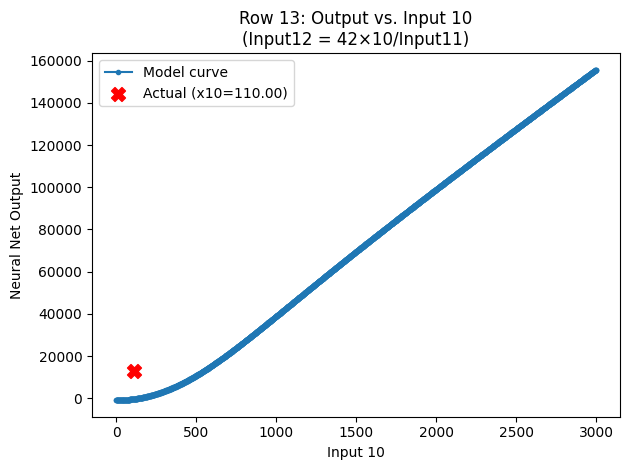

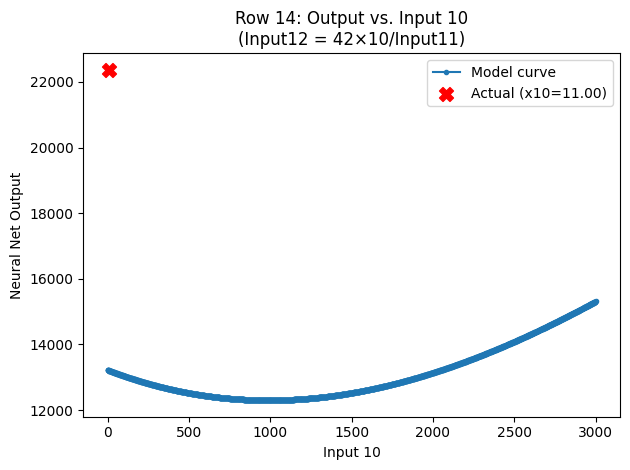

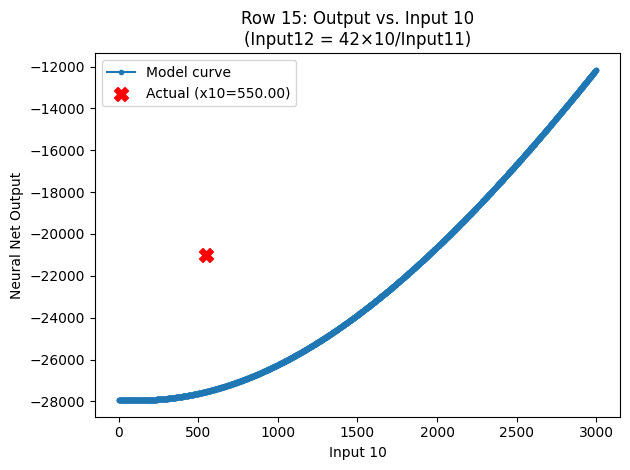

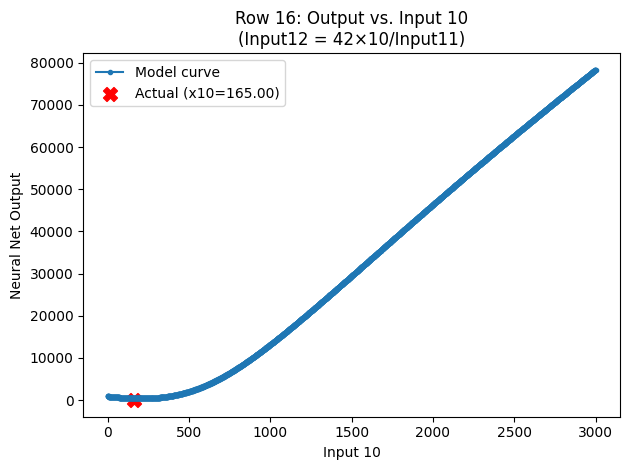

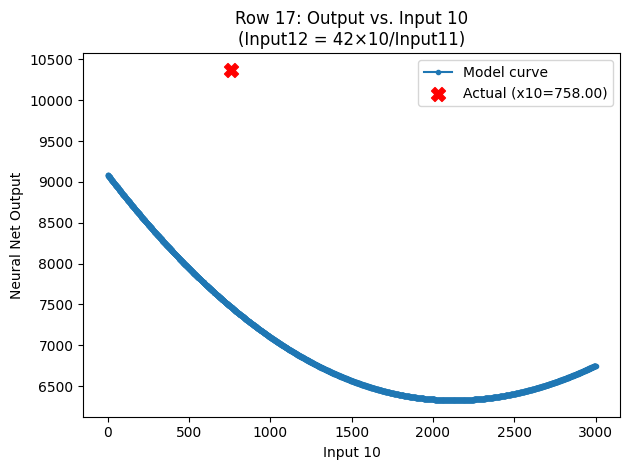

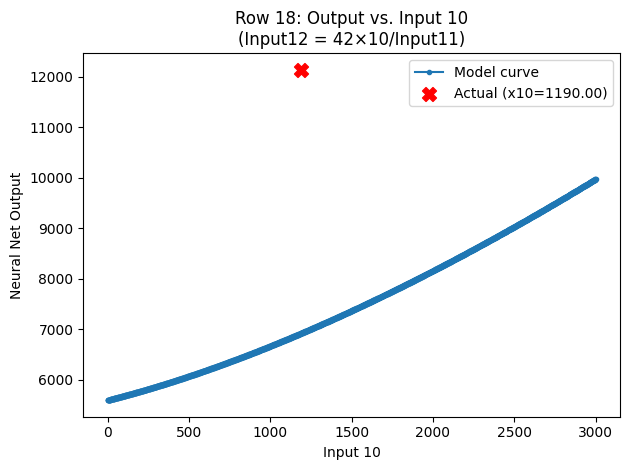

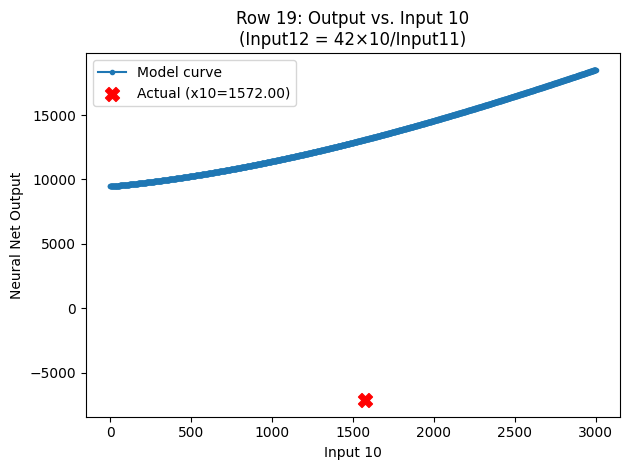

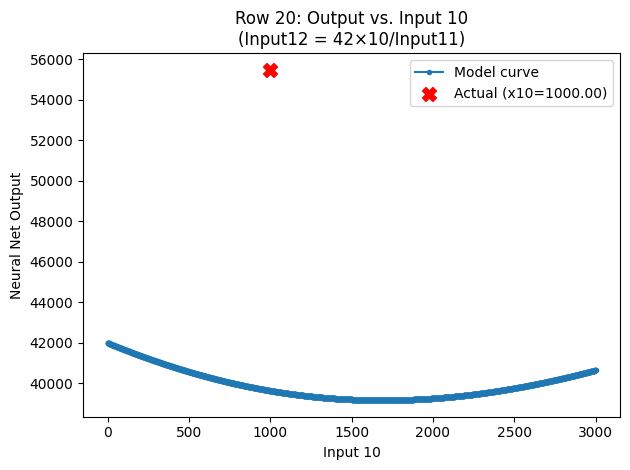

In [8]:
if __name__ == '__main__':
    DATA_PATH     = '/home/kamiar/chevron/Acid-neural-net/First data/data/test_cleaned.csv'
    MODEL_PATH    = '/home/kamiar/chevron/Acid-neural-net/First data/good_Models/trained_model_50c0e94e.pt'
    SCALER_X_PATH = 'scaler_X.pkl'
    SCALER_Y_PATH = 'scaler_y.pkl'
    HIDDEN_DIMS   = [8, 4]
    ACTIVATION    = 'Softplus'

    # Plot for *all* rows in the CSV
    plot_output_vs_input10(
        DATA_PATH, MODEL_PATH,
        SCALER_X_PATH, SCALER_Y_PATH,
        HIDDEN_DIMS, ACTIVATION,
        ROW_INDEX=-2
    )
